# Germanium Fano metasurface 

In this example, we reproduce the findings of Campione et al. (2016), which is linked [here](https://pubs.acs.org/doi/abs/10.1021/acsphotonics.6b00556?casa_token=v7Cq9VMW40UAAAAA:AWrBfYCHrwGQ9PYBYgdprrQ8X8i-nOairIplRs1Ejo2sbDmFT9nsV1M6UEXpvOfYSnwMjagD9IT97Ph2).

This notebook was originally developed and written by Romil Audhkhasi (USC). 

The paper investigates the resonances of Germanium structures by measuring their transmission spectrum under varying geometric parameters.

The paper uses a different commercial finite-difference time-domain software, which matches the result from Tidy3D.

<!-- <img src="img/Ge_struct.png" alt="diagram" width="300"/> -->

To do this calculation, we use a broadband pulse and frequency monitor to measure the flux on the opposite side of the structure.

Please check out another case study where we investigated a high-Q [silicon Fano resonator](https://www.flexcompute.com/tidy3d/examples/notebooks/HighQSi/). For more simulation examples, please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/). If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d as td
from tidy3d import web


## Set Up Simulation

In [2]:
Nfreq = 1000
wavelengths = np.linspace(8, 12, Nfreq)
freqs = td.constants.C_0 / wavelengths
freq0 = freqs[len(freqs) // 2]
freqw = freqs[0] - freqs[-1]

# Define material properties
n_BaF2 = 1.45
n_Ge = 4
BaF2 = td.Medium(permittivity=n_BaF2**2)
Ge = td.Medium(permittivity=n_Ge**2)


In [3]:
# space between resonators and source
spc = 8

# geometric parameters
Px = Py = P = 4.2
h = 2.53
L1 = 3.036
L2 = 2.024
w1 = w2 = w = 1.265

# resolution (should be commensurate with periodicity)
dl = P / 32


In [4]:
# total size in z and [x,y,z]
Lz = spc + h + h + spc
sim_size = [Px, Py, Lz]

# BaF2 substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -Lz / 2],
        size=[td.inf, td.inf, 2 * (spc + h)],
    ),
    medium=BaF2,
    name="substrate",
)

# Define structure

cell1 = td.Structure(
    geometry=td.Box(
        center=[(L1 / 2) - L2, -w1 / 2, h / 2],
        size=[L1, w1, h],
    ),
    medium=Ge,
    name="cell1",
)

cell2 = td.Structure(
    geometry=td.Box(
        center=[-L2 / 2, w2 / 2, h / 2],
        size=[L2, w2, h],
    ),
    medium=Ge,
    name="cell2",
)


In [5]:
# time dependence of source
gaussian = td.GaussianPulse(freq0=freq0, fwidth=freqw)

# plane wave source
source = td.PlaneWave(
    source_time=gaussian,
    size=(td.inf, td.inf, 0),
    center=(0, 0, Lz / 2 - spc + 2 * dl),
    direction="-",
    pol_angle=0,
)

# Simulation run time.  Note you need to run a long time to calculate high Q resonances.
run_time = 8e-11


In [6]:
# monitor fields on other side of structure (substrate side) at range of frequencies
monitor = td.FluxMonitor(
    center=[0.0, 0.0, -Lz / 2 + spc - 2 * dl],
    size=[td.inf, td.inf, 0],
    freqs=freqs,
    name="flux",
)


## Define Case Studies

Here we define the two simulations to run

- With no resonator (normalization)
- With Ge resonator


In [7]:
grid_spec = td.GridSpec(
    grid_x=td.UniformGrid(dl=dl),
    grid_y=td.UniformGrid(dl=dl),
    grid_z=td.AutoGrid(min_steps_per_wvl=32),
)

# normalizing run (no Ge) to get baseline transmission vs freq
# can be run for shorter time as there are no resonances
sim_empty = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate],
    sources=[source],
    monitors=[monitor],
    run_time=run_time / 10,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
    ),
)

# run with Ge nanorod
sim_actual = td.Simulation(
    size=sim_size,
    grid_spec=td.GridSpec.uniform(dl=dl),
    structures=[substrate, cell1, cell2],
    sources=[source],
    monitors=[monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
    ),
)


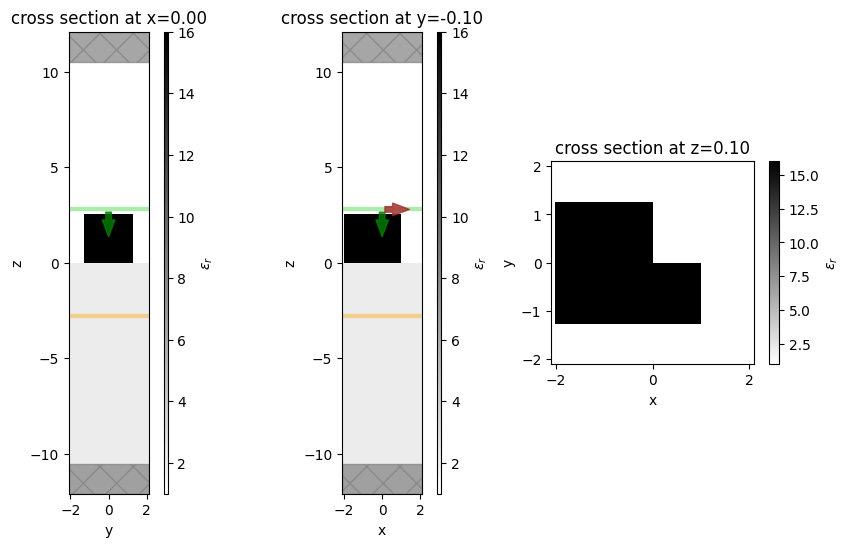

In [8]:
# Structure visualization in various planes

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))
sim_actual.plot_eps(x=0, ax=ax1)
sim_actual.plot_eps(y=-0.1, ax=ax2)
sim_actual.plot_eps(z=0.1, ax=ax3)
plt.show()


## Run Simulations

In [9]:
# run all simulations, take about 2-3 minutes each with some download time
batch = web.Batch(simulations={"norm": sim_empty, "actual": sim_actual}, verbose=True)
batch_data = batch.run(path_dir="data")


[13:08:11] Created task 'norm' with task_id                        ]8;id=459809;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=311755;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-22830c9d-a671-4e6a-be5a-6a257d8d6a42v1'.                       

           View task using web UI at                               ]8;id=63291;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=117365;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=565572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-22830c9d-a671-4e6a-be5a-6a257d8d6a42v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=296148;https://tidy3d.simulation.cloud/workbench?taskId=fdve-22830c9d-a671-4e6a-be5a-6a257d8d6a42v1\taskId]8;;\]8;id=565572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-22830c9d-a671-4e6a-be5a-6a257d8d6a42v1\=]8;;\]8;id=360503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-22830c9d-a671-4e6a-be5a-6a257d8d6a42v1\fdve]8;;\]8;id=565572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-22830c9d-a671-4e6a-be5a-6a257d8d6a42v1\-]8;;\              
           ]8;id=565572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-22830c9d-a671-4e6a-be5a-6a257d8d6a42v1\22830c9d-a671-4e6a-be5a-6a257d8d6a42v1']8;;\.                             

Output()

[13:08:12] Created task 'actual' with task_id                      ]8;id=358731;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=2120;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-3a0307fa-e221-47f4-981f-b26a276a3b39v1'.                       

           View task using web UI at                               ]8;id=970452;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=682415;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=336204;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3a0307fa-e221-47f4-981f-b26a276a3b39v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=632686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3a0307fa-e221-47f4-981f-b26a276a3b39v1\taskId]8;;\]8;id=336204;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3a0307fa-e221-47f4-981f-b26a276a3b39v1\=]8;;\]8;id=849018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3a0307fa-e221-47f4-981f-b26a276a3b39v1\fdve]8;;\]8;id=336204;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3a0307fa-e221-47f4-981f-b26a276a3b39v1\-]8;;\              
           ]8;id=336204;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3a0307fa-e221-47f4-981f-b26a276a3b39v1\3a0307fa-e221-47f4-981f-b26a276a3b39v1']8;;\.                             

Output()

[13:08:13] Started working on Batch.                            ]8;id=713470;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=494943;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#475\475]8;;\

[13:08:23] Maximum FlexCredit cost: 0.054 for the whole batch.  ]8;id=199058;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=121566;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#479\479]8;;\
           Use 'Batch.real_cost()' to get the billed FlexCredit                 
           cost after the Batch has completed.                                  

Output()

[13:09:24] Batch complete.                                      ]8;id=151506;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=645320;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#522\522]8;;\

The normalizing run computes the transmitted flux for an air -> SiO2 interface, which is just below unity due to some reflection.

While not technically necessary for this example, since this transmission can be computed analytically, it is often a good idea to run a normalizing run so you can accurately measure the *change* in output when the structure is added.  For example, for multilayer structures, the normalizing run displays frequency dependence, which would make it prudent to include in the calculation.

In [10]:
batch_data = batch.load(path_dir="data")
transmission = batch_data["actual"]["flux"].flux / batch_data["norm"]["flux"].flux
reflection = 1 - transmission


Output()

[13:09:26] loading SimulationData from                             ]8;id=972550;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=889407;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-3a0307fa-e221-47f4-981f-b26a276a3b39v1.hdf5                

Output()

[13:09:27] loading SimulationData from                             ]8;id=752890;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=806617;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-22830c9d-a671-4e6a-be5a-6a257d8d6a42v1.hdf5                

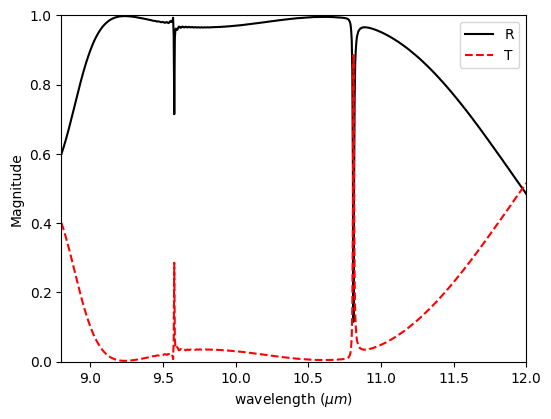

In [11]:
# plot transmission, compare to paper results, look similar
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(wavelengths, reflection, "k", label="R")
plt.plot(wavelengths, transmission, "r--", label="T")
plt.xlabel("wavelength ($\mu m$)")
plt.ylabel("Magnitude")
plt.xlim([8.8, 12])
plt.ylim([0.0, 1.0])
plt.legend()
plt.show()


<!-- <img src="img/Ge_plot.png" alt="diagram" width="300"/> -->

Besides the metasurface demonstrated in this notebook, in Tidy3D's example library we have demonstrated a [dielectric metasurface absorber](https://www.flexcompute.com/tidy3d/examples/notebooks/DielectricMetasurfaceAbsorber/), a [gradient metasurface reflector](https://www.flexcompute.com/tidy3d/examples/notebooks/GradientMetasurfaceReflector/), a [metalens at the visible frequency](https://www.flexcompute.com/tidy3d/examples/notebooks/Metalens/), and a [graphene metamaterial absorber](https://www.flexcompute.com/tidy3d/examples/notebooks/GrapheneMetamaterial/). 